In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("SI")

SI


In [2]:
# Load the datasets
train = pd.read_csv("/home/intern/Desktop/spyder/fsmpd/train.csv")
test = pd.read_csv("/home/intern/Desktop/spyder/fsmpd/test.csv")

In [3]:
train

,no abuse report,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.00,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.00,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.00,0,0,0,1,13,159,98,0
3,1,0.00,1,0.00,0,82,0,0,679,414,651,0
4,1,0.00,2,0.00,0,0,0,1,6,151,126,0
...,...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1


In [4]:
# Split the training set
train_X = train.drop(columns='fake')
train_Y = train.fake

# Split the test set
test_X = test.drop(columns='fake')
test_Y = test.fake


Correlation of each feature with 'fake':
fake                    1.000000
nums/length username    0.587687
nums/length fullname    0.246782
name==username          0.170695
private                -0.028586
#followers             -0.093689
#follows               -0.224835
#posts                 -0.245355
fullname words         -0.298793
external URL           -0.362809
description length     -0.460825
no abuse report        -0.637315
Name: fake, dtype: float64


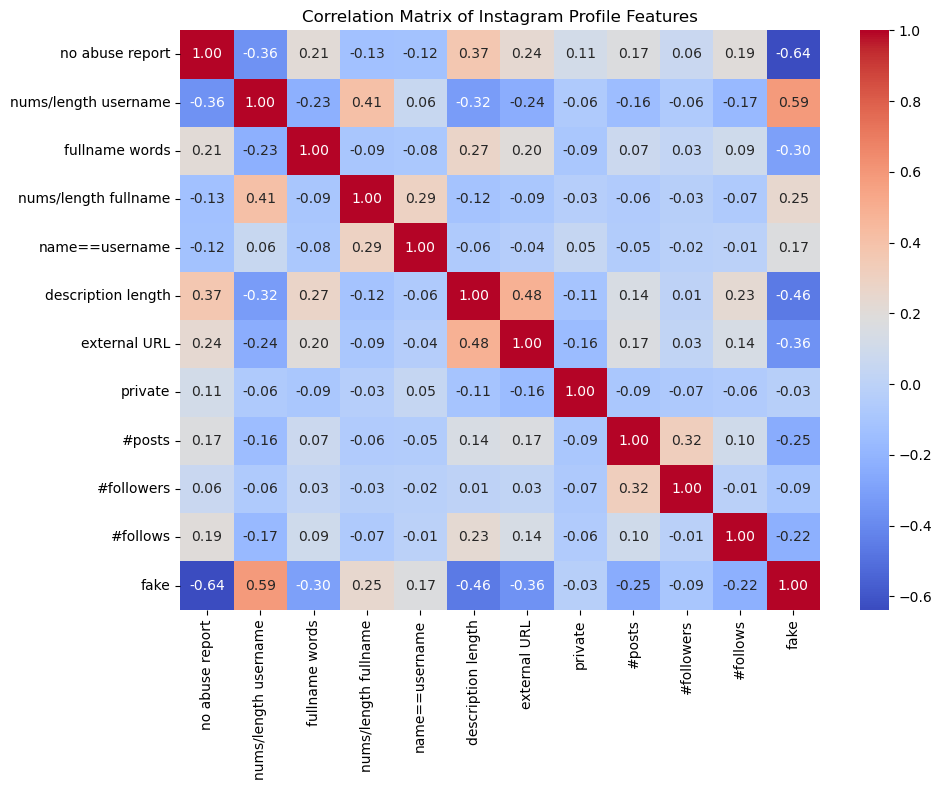

In [5]:
# Let's examine the correlation between features and the target variable
correlation_with_target = train.corr()['fake'].sort_values(ascending=False)
print("Correlation of each feature with 'fake':")
print(correlation_with_target)

# Visualize the correlations
plt.figure(figsize=(10, 8))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Instagram Profile Features')
plt.tight_layout()
plt.show()

In [6]:
# Let's create a correlation-based detector using the top correlated features
# We'll use a weighted sum approach based on correlation strengths

def correlation_based_predict(X_data, correlation_weights, threshold):
    """
    Make predictions based on correlation weights of features.
    
    Parameters:
    X_data - DataFrame with features
    correlation_weights - Series with feature correlations
    threshold - Decision threshold for classification
    
    Returns:
    numpy array of predictions (1 for fake, 0 for authentic)
    """
    # Get absolute correlation values (ignoring sign)
    abs_corr = correlation_weights.abs()
    
    # Exclude the 'fake' column itself if present
    if 'fake' in abs_corr:
        abs_corr = abs_corr.drop('fake')
    
    # Get feature names and normalize the weights
    features = abs_corr.index
    total_corr = abs_corr.sum()
    normalized_weights = abs_corr / total_corr
    
    # Calculate weighted scores for each example
    scores = np.zeros(len(X_data))
    
    for feature in features:
        # Take into account the direction of correlation
        direction = 1 if correlation_weights[feature] > 0 else -1
        # Normalize the feature values to [0, 1] scale
        feature_min = X_data[feature].min()
        feature_max = X_data[feature].max()
        if feature_max > feature_min:
            normalized_feature = (X_data[feature] - feature_min) / (feature_max - feature_min)
        else:
            normalized_feature = X_data[feature] * 0  # Handle the case where all values are the same
        
        # Apply direction (if positive correlation, higher values contribute to "fake")
        # If negative correlation, lower values contribute to "fake"
        if direction < 0:
            normalized_feature = 1 - normalized_feature
            
        # Add weighted contribution to the score
        scores += normalized_weights[feature] * normalized_feature
    
    # Convert scores to binary predictions
    predictions = (scores > threshold).astype(int)
    return predictions

In [7]:
# Let's find the best threshold value on the training set
thresholds = np.arange(0.3, 0.7, 0.001)
best_accuracy = 0
best_threshold = 0.5

for threshold in thresholds:
    train_preds = correlation_based_predict(train_X, correlation_with_target, threshold)
    accuracy = accuracy_score(train_Y, train_preds)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Best threshold on training data: {best_threshold:.3f} with accuracy: {best_accuracy:.4f}")

Best threshold on training data: 0.513 with accuracy: 0.9062


In [8]:
# Make predictions on the test set using the best threshold
test_predictions = correlation_based_predict(test_X, correlation_with_target, best_threshold)
test_accuracy = accuracy_score(test_Y, test_predictions)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Print detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(test_Y, test_predictions))


Test set accuracy: 0.8833

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        60
           1       0.90      0.87      0.88        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.88      0.88      0.88       120




Confusion Matrix:
[[54  6]
 [ 8 52]]


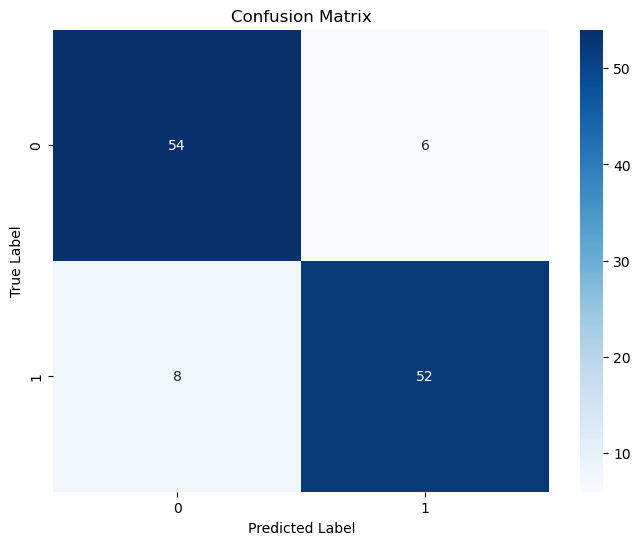

In [9]:
print("\nConfusion Matrix:")
cm = confusion_matrix(test_Y, test_predictions)
print(cm)

# Visualize results
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


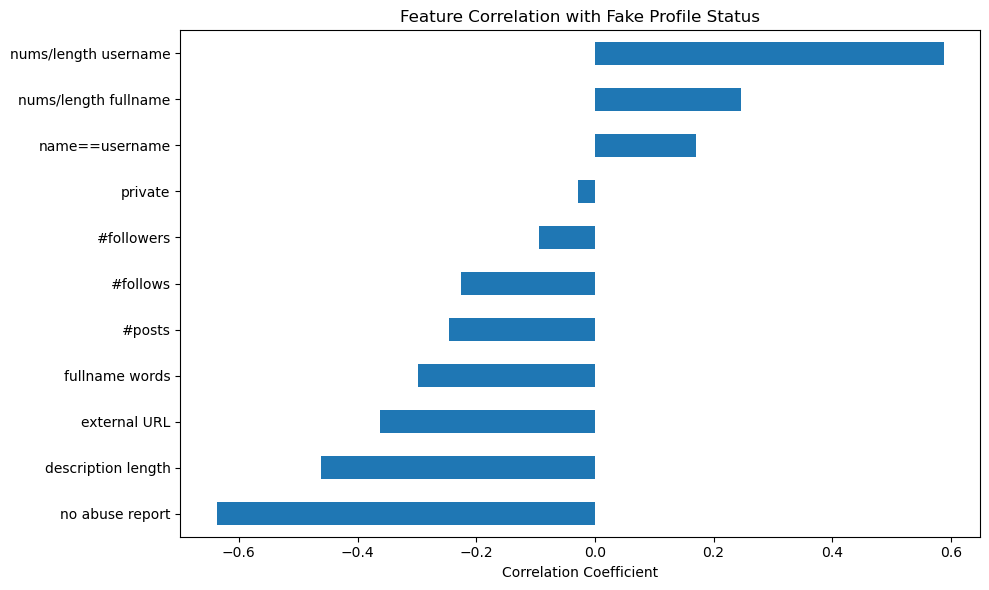

In [10]:
# Feature importance visualization based on correlation
plt.figure(figsize=(10, 6))
correlation_with_target.drop('fake').sort_values().plot(kind='barh')
plt.title('Feature Correlation with Fake Profile Status')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

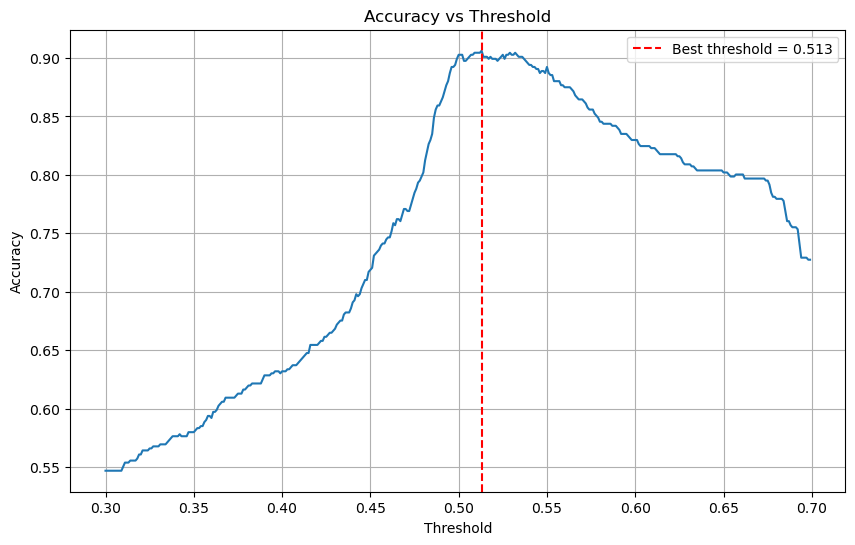

In [11]:
# Let's also try a threshold optimization strategy
# Plot accuracy vs threshold
plt.figure(figsize=(10, 6))
accuracies = []
for threshold in thresholds:
    train_preds = correlation_based_predict(train_X, correlation_with_target, threshold)
    accuracies.append(accuracy_score(train_Y, train_preds))

plt.plot(thresholds, accuracies)
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold = {best_threshold:.3f}')
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Let's see if feature selection improves performance
# We'll use only features with absolute correlation above a certain threshold
correlation_threshold = 0.4
significant_features = correlation_with_target.drop('fake').abs()[correlation_with_target.drop('fake').abs() > correlation_threshold].index.tolist()

print(f"\nUsing only {len(significant_features)} significant features:")
n = 1
for i in significant_features:
    print(str(n)+")",i)
    n += 1


Using only 3 significant features:
1) nums/length username
2) description length
3) no abuse report


In [13]:
# Function to make predictions using only significant features
def selective_correlation_predict(X_data, correlation_weights, selected_features, threshold=0.5):
    # Filter data and weights to only include selected features
    X_filtered = X_data[selected_features]
    weights_filtered = correlation_weights[selected_features]
    return correlation_based_predict(X_filtered, weights_filtered, threshold)

# Find the best threshold for the significant features approach
best_accuracy_filtered = 0
best_threshold_filtered = 0.5

for threshold in thresholds:
    train_preds = selective_correlation_predict(train_X, correlation_with_target, significant_features, threshold)
    accuracy = accuracy_score(train_Y, train_preds)
    if accuracy > best_accuracy_filtered:
        best_accuracy_filtered = accuracy
        best_threshold_filtered = threshold

print(f"Best threshold with selected features: {best_threshold_filtered:.3f} with accuracy: {best_accuracy_filtered:.4f}")


Best threshold with selected features: 0.340 with accuracy: 0.8976


In [14]:
# Test set predictions with selected features
test_predictions_filtered = selective_correlation_predict(test_X, correlation_with_target, significant_features, best_threshold_filtered)
test_accuracy_filtered = accuracy_score(test_Y, test_predictions_filtered)
print(f"Test set accuracy with selected features: {test_accuracy_filtered:.4f}")

# Compare with Logistic Regression accuracy from previous code
print("\nComparison of methods:")
print(f"1. Statistical ratio method accuracy: {max(accuracies):.4f}")
print(f"2. Full correlation-based method accuracy: {test_accuracy:.4f}")
print(f"3. Selected features correlation-based method accuracy: {test_accuracy_filtered:.4f}")

Test set accuracy with selected features: 0.9000

Comparison of methods:
1. Statistical ratio method accuracy: 0.9062
2. Full correlation-based method accuracy: 0.8833
3. Selected features correlation-based method accuracy: 0.9000


In [15]:
# Also let's create a simple rule-based detector using the top 3 most correlated features
top_features = correlation_with_target.drop('fake').abs().sort_values(ascending=False).head(3).index.tolist()
print(f"\nTop 3 correlated features: {top_features}")


Top 3 correlated features: ['no abuse report', 'nums/length username', 'description length']


In [16]:
def rule_based_predict(X_data, correlation_weights, top_features, threshold=0.5):
    # Simple approach using just the top features with custom weights
    scores = np.zeros(len(X_data))
    
    for feature in top_features:
        direction = 1 if correlation_weights[feature] > 0 else -1
        # Normalize the feature values
        feature_min = X_data[feature].min()
        feature_max = X_data[feature].max()
        if feature_max > feature_min:
            normalized_feature = (X_data[feature] - feature_min) / (feature_max - feature_min)
        else:
            normalized_feature = X_data[feature] * 0
        
        if direction < 0:
            normalized_feature = 1 - normalized_feature
            
        # Use the absolute correlation as the weight
        scores += abs(correlation_weights[feature]) * normalized_feature
    
    # Normalize the scores
    scores = scores / sum(abs(correlation_weights[top_features]))
    
    # Convert scores to binary predictions
    predictions = (scores > threshold).astype(int)
    return predictions


In [17]:
# Find the best threshold for the rule-based approach
best_accuracy_rule = 0
best_threshold_rule = 0.5

for threshold in thresholds:
    train_preds = rule_based_predict(train_X, correlation_with_target, top_features, threshold)
    accuracy = accuracy_score(train_Y, train_preds)
    if accuracy > best_accuracy_rule:
        best_accuracy_rule = accuracy
        best_threshold_rule = threshold

print(f"Best threshold for rule-based method: {best_threshold_rule:.3f} with accuracy: {best_accuracy_rule:.4f}")


Best threshold for rule-based method: 0.340 with accuracy: 0.8976


In [18]:
# Test set predictions with rule-based approach
test_predictions_rule = rule_based_predict(test_X, correlation_with_target, top_features, best_threshold_rule)
test_accuracy_rule = accuracy_score(test_Y, test_predictions_rule)
print(f"Test set accuracy with rule-based method: {test_accuracy_rule:.4f}")


Test set accuracy with rule-based method: 0.9000


In [19]:

# Update comparison
print("\nUpdated comparison of methods:")
print(f"1. Statistical ratio method accuracy: {max(accuracies):.4f}")
print(f"2. Full correlation-based method accuracy: {test_accuracy:.4f}")
print(f"3. Selected features correlation-based method accuracy: {test_accuracy_filtered:.4f}")
print(f"4. Simple rule-based method with top 3 features: {test_accuracy_rule:.4f}")


Updated comparison of methods:
1. Statistical ratio method accuracy: 0.9062
2. Full correlation-based method accuracy: 0.8833
3. Selected features correlation-based method accuracy: 0.9000
4. Simple rule-based method with top 3 features: 0.9000


In [20]:
# Create the model dictionary without functions
correlation_model = {
    'correlation_weights': correlation_with_target,
    'best_threshold': best_threshold,
    'selected_features': significant_features,
    'best_threshold_filtered': best_threshold_filtered,
    'top_features': top_features,
    'best_threshold_rule': best_threshold_rule,
    'feature_min_max': {feature: (train_X[feature].min(), train_X[feature].max()) for feature in train_X.columns}
}

# Save using pickle
import pickle
with open('correlation_model.pkl', 'wb') as file:
    pickle.dump(correlation_model, file)
